In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='0000',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/91999/Desktop/Projects/E-Commerce Target Sales/Data'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [33]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "0000",
                             database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located.

In [3]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [4]:
query = """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data=cur.fetchall()

"total orders place in year 2017 were",data[0][0]

('total orders place in year 2017 were', 45101)

# Find the total sales per category.

In [5]:
import pandas as pd
query = """select upper(products.product_category) as category,
round(sum(payments.payment_value),2) as sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id=order_items.order_id
group by category
"""

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data,columns=["Catgory","Sales"])
df

,Catgory,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [6]:
query = """select round(sum(case when payment_installments >= 1
then 1 else 0 end)*100/count(order_id),4)
as installment_percentage from payments;"""

cur.execute(query)

data=cur.fetchall()

"the percentage of orders that were paid in installments",data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

# Count the number of customers from each state. 

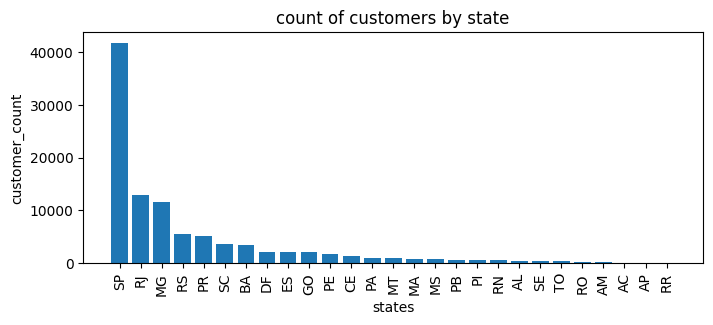

In [7]:
query = """select customer_state,count(customer_id) as total_customers_each_city from customers
group by customer_state"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns =["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)

plt.figure(figsize=(8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customers by state")
plt.show()

# Calculate the number of orders per month in 2018.

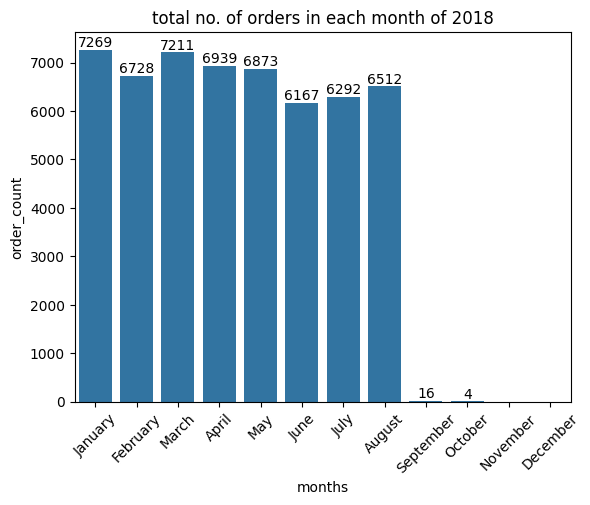

In [8]:
query = """select monthname(order_purchase_timestamp) as months,count(order_id) as order_count
from orders where order_purchase_timestamp=2018
group by months"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data, columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October","November","December"]
ax=sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("total no. of orders in each month of 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [11]:
query = """with count_per_order as (select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["city","average orders"])
df.head(10)

,city,average orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [15]:
query = """select upper(products.product_category) as category,round(sum(payments.payment_value)/(select sum(payment_value) from payments) *100,2) as sales_percentage from payments
join order_items on payments.order_id=order_items.order_id
join products on order_items.product_id=products.product_id
group by category order by sales_percentage desc;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["products","percentage sales"])
df.head()

,products,percentage sales
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [20]:
import numpy as np
query = """select products.product_category as category,count(order_items.product_id),round(avg(order_items.price),2) from order_items
join orders on orders.order_id=order_items.order_id
join products on order_items.product_id=products.product_id
group by category;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["products","order quantity","avg price"])
arr1=df["order quantity"]
arr2=df["avg price"]
a=np.corrcoef([arr1,arr2])
print("the correlation is",a[0][-1])

the correlation is -0.10631514167157566


# Calculate the total revenue generated by each seller, and rank them by revenue.

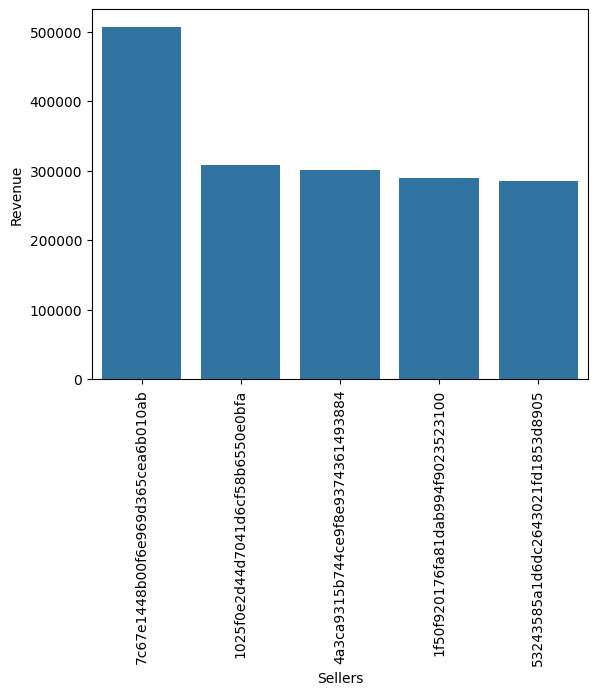

In [29]:
query = """select *,dense_rank() over(order by revenue desc) as rnk from
(select sellers.seller_id,round(sum(payments.payment_value),2) as revenue from payments
join order_items on payments.order_id=order_items.order_id
join sellers on sellers.seller_id=order_items.seller_id
group by sellers.seller_id) as a;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns= ["Sellers","Revenue","Rank"])
df=df.head()
sns.barplot(x="Sellers",y="Revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [31]:
query = """select customer_id,order_purchase_timestamp,payment_value,
avg(payment_value) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value from orders
join payments on orders.order_id=payments.order_id) as a;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [3]:
query = """select years,months,payment,sum(payment)
over(order by years,months) as cumulative_payment
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from payments
join orders on payments.order_id=orders.order_id
group by years,months) as a;"""

cur.execute(query)

data=cur.fetchall()
data

[(2016, 9, 252.24, 252.24),
 (2016, 10, 59090.48, 59342.72),
 (2016, 12, 19.62, 59362.340000000004),
 (2017, 1, 138488.04, 197850.38),
 (2017, 2, 291908.01, 489758.39),
 (2017, 3, 449863.6, 939621.99),
 (2017, 4, 417788.03, 1357410.02),
 (2017, 5, 592918.82, 1950328.8399999999),
 (2017, 6, 511276.38, 2461605.2199999997),
 (2017, 7, 592382.92, 3053988.1399999997),
 (2017, 8, 674396.32, 3728384.4599999995),
 (2017, 9, 727762.45, 4456146.909999999),
 (2017, 10, 779677.88, 5235824.789999999),
 (2017, 11, 1194882.8, 6430707.589999999),
 (2017, 12, 878401.48, 7309109.069999998),
 (2018, 1, 1115004.18, 8424113.249999998),
 (2018, 2, 992463.34, 9416576.589999998),
 (2018, 3, 1159652.12, 10576228.709999997),
 (2018, 4, 1160785.48, 11737014.189999998),
 (2018, 5, 1153982.15, 12890996.339999998),
 (2018, 6, 1023880.5, 13914876.839999998),
 (2018, 7, 1066540.75, 14981417.589999998),
 (2018, 8, 1022425.32, 16003842.909999998),
 (2018, 9, 4439.54, 16008282.449999997),
 (2018, 10, 589.67, 16008872.11

# Calculate the year-over-year growth rate of total sales.

In [15]:
query = """with a as (select year(orders.order_purchase_timestamp) as years ,
round(sum(payments.payment_value),2) as revenue from payments 
join orders on orders.order_id=payments.order_id
group by years order by years)

select years,((revenue-lag(revenue,1) over (order by years))/
lag(revenue,1) over (order by years)) * 100 from a;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","yoy % growth"])
df.head()

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [16]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order 
from orders join customers 
on orders.customer_id=customers.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) as next_order
from a join orders 
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b 
on a.customer_id=b.customer_id;"""

cur.execute(query)

data=cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

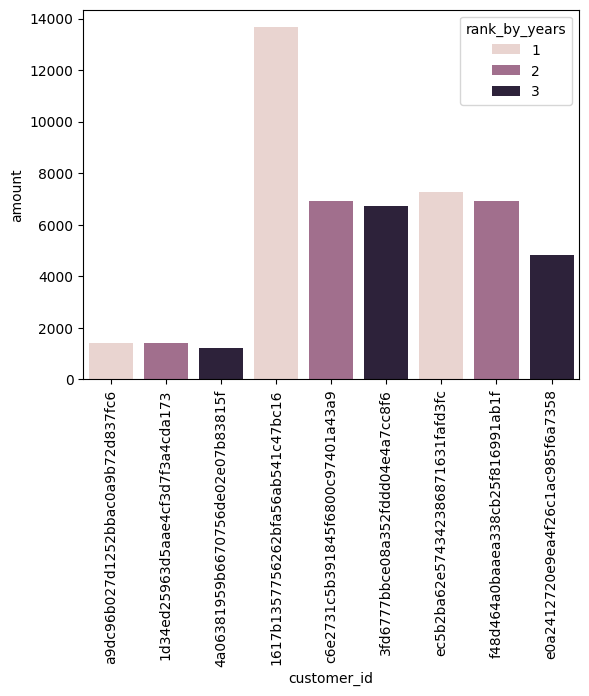

In [26]:
query = """select years,customer_id,payment,d_rank from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
round(sum(payments.payment_value),2) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","customer_id","amount","rank_by_years"])
sns.barplot(x="customer_id",y="amount",data=df,hue="rank_by_years")
plt.xticks(rotation=90)
plt.show()